# Metody obliczeniowe w nauce i technice

# Laboratorium 4 - Symulowane wyżarzanie

In [274]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from copy import deepcopy

Funkcja generująca punkty w czterech skupiskach, żeby lepiej było widać jakość znalezionego przybliżenia cyklu Hamiltona.

In [208]:
def generate_points(n):
    points = []
    to_choose = [(1, 11, 1, 11), (21, 31, 1, 11), (21, 31, 21, 31), (1, 11, 21, 31)]
    quarter = n // 4
    rest = n % 4
    
    for _ in range(quarter):
        points.append((random.randint(1, 11), random.randint(1, 11)))
        points.append((random.randint(21, 31), random.randint(1, 11)))
        points.append((random.randint(21, 31), random.randint(21, 31)))
        points.append((random.randint(1, 11), random.randint(21, 31)))
    
    for _ in range(rest):
        x = random.choice(to_choose)
        points.append((random.randint(x[0], x[1]), random.randint(x[2], x[3])))
    
    return points

In [233]:
def plot_points(points, cycle=None):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.scatter(x, y, zorder=2)
    
    if cycle is not None:
        cycle_x = [points[i][0] for i in cycle] + [points[cycle[0]][0]]
        cycle_y = [points[i][1] for i in cycle] + [points[cycle[0]][1]]
        plt.plot(cycle_x, cycle_y, color='orange', zorder=1, marker='o')
    
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [236]:
def plot_solution(x, y, label):
    plt.plot(x, y)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title(label)
    plt.grid(True)
    plt.show()

Do wygenerowania zbioru punktów ```fixed_sample``` użyłem funkcji ```generate_points```.

In [213]:
fixed_sample = [(1, 9), (29, 1), (27, 22), (10, 22), (11, 5), (30, 1), (23, 25), (5, 27), (7, 6), (25, 3), (29, 27), (5, 27), (7, 5), (23, 9), (30, 26), (1, 31), (6, 11), (25, 5), (26, 22), (1, 25), (5, 5), (27, 7), (29, 28), (2, 21), (11, 3), (29, 2), (22, 23), (11, 29), (7, 11), (22, 11), (27, 22), (5, 31), (4, 3), (21, 1), (27, 23), (4, 26), (3, 8), (22, 11), (31, 30), (8, 22)]

Funkcja ```euclidean_distance``` oblicza odległość pomiędzy dwoma punktami na płaszczyźnie kartezjańskiej, a funkcja ```calculate_distances``` tworzy macierz odległości pomiędzy wszystkimi parami punktów.

In [214]:
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [215]:
def calculate_distances(points):
    n = len(points)
    distances = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            distance = euclidean_distance(points[i], points[j])
            distances[i][j] = distance
            distances[j][i] = distance
    
    return distances

In [216]:
ds = calculate_distances(fixed_sample)

Funkcja ```calculate_path_length``` oblicza długość danego cyklu, korzystając z macierzy odległości.

In [217]:
def calculate_path_length(permutation, distances):
    result = 0
    n = len(permutation)
    for i in range(n - 1):
        result += distances[permutation[i]][permutation[i + 1]]
    
    result += distances[permutation[n - 1]][permutation[0]]
    
    return result

In [218]:
def generate_two_unique_numbers(n):
    numbers = list(range(n))
    selected_numbers = random.sample(numbers, 2)
    return selected_numbers

**Doprecyzowanie:** Za "temperaturę" rozumiem prawdopodobieństwo wyboru **gorszego** rozwiązania w danej iteracji. Dopełnieniem temperatury do $1$ jest prawdopodobieństwo wyboru **lepszego** rozwiązania.

Funkcja ```polynomial_change```, definiuje jak szybko spada temperatura w danym algorytmie symulowanego wyżarzania.

Jest to funkcja wielomianowa postaci $ax^t + b$, której argumentem jest numer iteracji, a wartością funkcji, prawdopodobieństwo wyboru **lepszego** rozwiązania.

Parametry $a$ i $b$ są dobrane tak, żeby funkcja dla pierwszej iteracji była równa startowemu prawdopodobieństwu wyboru **lepszego** rozwiązania, a dla ostatniej iteracji $1$

Spadek temperatury opisuje funkcja $1 -$ ```polynomial_change```.

In [219]:
def polynomial_change(x, a, t, st):
    return a*(x**t) + st

In [220]:
def test_polynomial_change(f, t, st, desired, iterations):
    a = (desired - st)/(iterations**t)
    values = []
    for i in range(iterations):
        values.append(1 - f(i, a, t, st))
    
    return values

Tu jest przykład liniowego spadku temperatury, czyli funkcji ```polynomial_change``` z wartością parametru $t$ równą $1$.

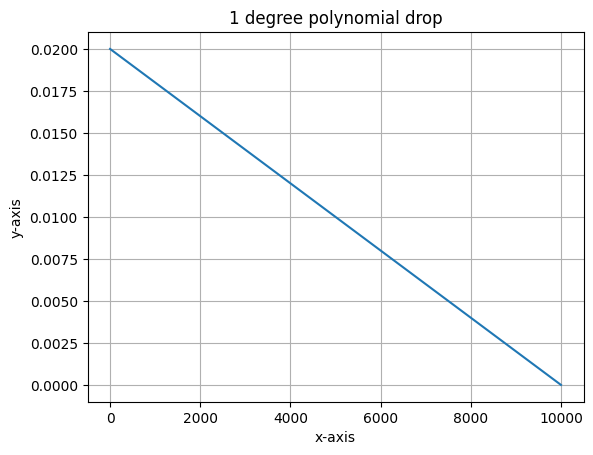

In [239]:
degree = 1
y = test_polynomial_change(polynomial_change, 1, 0.98, 1, 10000)
x3 = list(range(len(y)))
plot_solution(x3, y, str(degree) + " degree polynomial drop")

## Implementacja algorytmu symulowanego wyżarzania do przybliżania problemu komiwojażera.

Parametrami algorytmu są kolejno:
- ```st``` startowe prawdopodobieństwo wyboru **lepszego** rozwiązania
- ```f``` funkcja według której temperatura będzie spadać
- ```t``` parametr do funkcji ```polynomial_change``` określający stopień wielomianu
- ```iterations``` liczba iteracji
- ```mat``` macierz odległości dla danego zbioru punktów

In [258]:
def tsp(st, f, t, iterations, mat):
    n = len(mat)
    states = []
    permutation = list(range(n)) 
    random.shuffle(permutation)
    best_so_far = (float('inf'), -1)
    
    var = (1 - st)/(iterations**t)
    heat = st
    
    for i in range(iterations):
        length1 = calculate_path_length(permutation, mat)
        states.append(length1)
        candidate = deepcopy(permutation)
        a, b = generate_two_unique_numbers(n)
        candidate[a], candidate[b] = candidate[b], candidate[a]
        length2 = calculate_path_length(candidate, mat)
        best_so_far = min(best_so_far, min((length1, permutation), (length2, candidate)))
        
        if calculate_path_length(permutation, mat) > calculate_path_length(candidate, mat):
            permutation, candidate = candidate, permutation
        
        if random.random() > heat:
            permutation, candidate = candidate, permutation
        
        heat = f(i, var, t, st)
    
    return best_so_far, states

In [259]:
def test_tsp(st, f, t, iterations, mat):
    result, graph = tsp(st, f, t, iterations, mat)
    x = list(range(len(graph)))
    plot_solution(x, graph, "Path length")
    plot_points(fixed_sample)
    plot_points(fixed_sample, result[1])
    print("Best path length achieved: ", result[0])

Najlepszy wynik jaki udało mi się uzyskać.

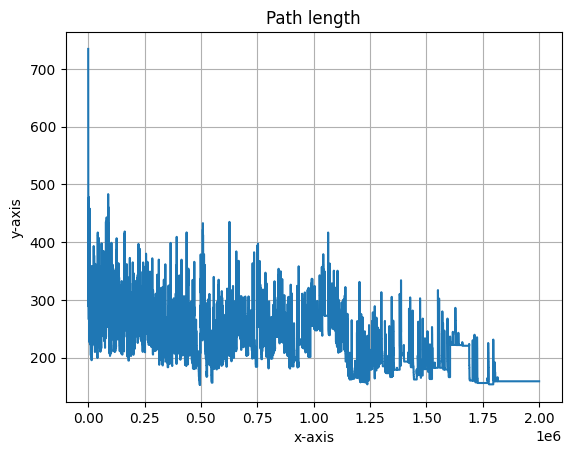

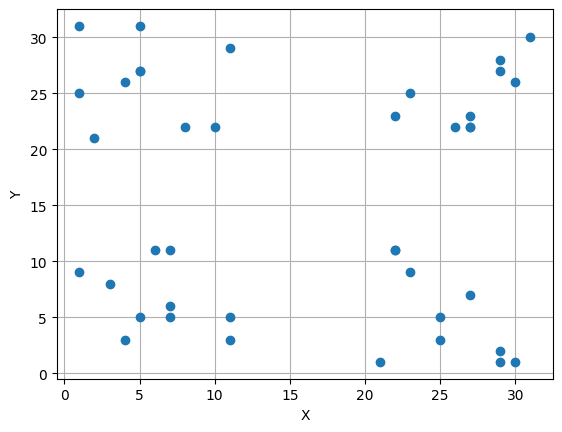

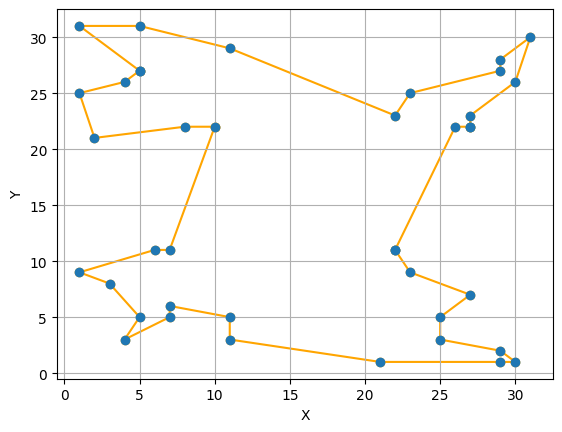

Best path length achieved:  152.61848214256048


In [260]:
test_tsp(0.99, polynomial_change, 0.05, 2000000, ds)

Dla porównania napisałem prymitywny algorytm, który w każdej iteracji losuje całkowicie nową permutację i jeżeli jest lepsza, to zawsze ją bierze.

In [277]:
def full_random(iterations, mat):
    n = len(mat)
    states = []
    different_permutations = set()
    best_permutation = list(range(n)) 
    random.shuffle(best_permutation)
    different_permutations.add(tuple(best_permutation))
    for _ in range(iterations):
        new_permutation = list(range(n))
        random.shuffle(new_permutation)
        different_permutations.add(tuple(new_permutation))
        
        l1 = calculate_path_length(best_permutation, mat)
        l2 = calculate_path_length(new_permutation, mat)
        
        if l1 > l2:
            best_permutation = new_permutation
        
        states.append(min(l1, l2))
    
    return states, best_permutation, len(different_permutations)
        

In [280]:
def test_full_random(iterations):
    graph, res, dp = full_random(iterations, ds)
    x = list(range(len(graph)))
    plot_solution(x, graph, "Path length")
    print()
    plot_points(fixed_sample, res)
    print("Best path length achieved: ", calculate_path_length(res, ds))
    print("Repeated permutations checked: ", iterations - dp + 1)

Jak widzimy, dla takiej samej liczby iteracji, cykl $3$ razy dłuższy.

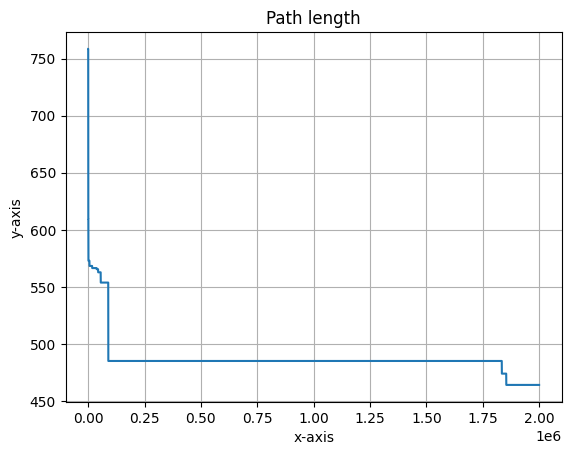

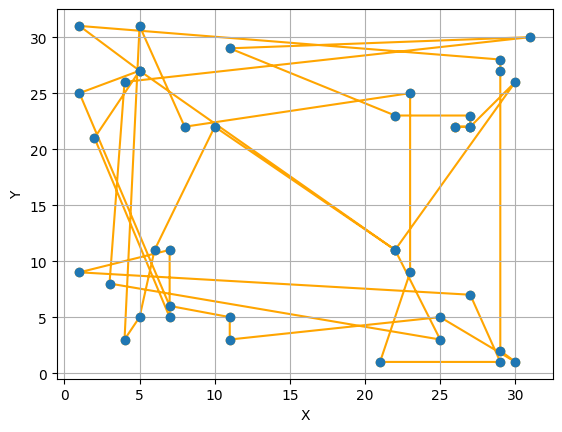

Best path length achieved:  464.17182796348567
Repeated permutations checked:  0


In [281]:
test_full_random(2000000)

Funkcja ```check_different_parameters``` to pomocnicza funkcja, która pozwala mi przetestować algorytm dla różnych początkowych temperatur i funkcji spadku temperatury

Wielokrotnie odpala ona algorytm z różnymi parametrami i zwraca tylko najlepsze wyniki

In [19]:
def check_different_parameters(A, B, C):
    results = []
    n, iterations = C
    for _ in range(n):
        current_run = []
        for a in A:
            for b in B:
                temp, level, shortest = tsp(a, polynomial_change, b, iterations, ds)
                current_run.append((shortest, temp, level))
        
        results.append(current_run)
    
    return results

In [161]:
# temps = [0.9, 0.95, 0.97, 0.98, 0.99]
temps = [0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99]
degrees = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 4, 6, 8, 10, 20]
ite = (10, 100000)
results = check_different_parameters(temps, degrees, ite)

for run in results:
    run.sort()
    print(run[:5])
        

[(158.1992284255189, 0.99, 0.75), (163.53761774291195, 0.99, 0.25), (166.79419533486396, 0.99, 10), (168.0990367513753, 0.99, 0.5), (168.62763937372767, 0.98, 1.5)]
[(167.8420472481047, 0.99, 1), (174.82710052384658, 0.99, 8), (176.02500447793037, 0.97, 0.25), (182.79604166439893, 0.98, 0.25), (183.6632155841646, 0.99, 0.75)]
[(172.7259880580023, 0.97, 0.25), (179.78699791854453, 0.98, 0.1), (182.83671926367293, 0.97, 0.1), (183.2586421325749, 0.98, 0.25), (186.35707433669685, 0.95, 0.25)]
[(169.56766043157796, 0.99, 0.75), (171.6864379330013, 0.98, 0.1), (184.1609411338485, 0.99, 0.1), (184.5057023566227, 0.95, 0.75), (185.15173704400058, 0.9, 1.5)]
[(157.76878246916058, 0.99, 0.1), (166.60530908685027, 0.98, 0.1), (170.32872054572906, 0.99, 4), (175.3099261726967, 0.95, 1), (176.60266192390068, 0.7, 0.1)]
[(177.40770783077423, 0.99, 0.75), (178.28364244594763, 0.7, 0.1), (179.60931695969649, 0.97, 0.1), (180.66458404636222, 0.98, 0.1), (181.16049308290238, 0.99, 4)]
[(160.03627768305

Jak widzimy, najlepsze rezultaty osiągamy przy niskich temperaturach rzędu $0.01 - 0.03$, oraz przy niskich stopniach wielomianu $t \in [0.1, 1.0]$

In [42]:
def draw_image(image):
    fig, ax = plt.subplots()
    cax = ax.matshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    fig.colorbar(cax)
    plt.axis('off')
    plt.show()

In [43]:
def generate_random_image(values, l, dark_density):
    image = []
    light = values[:len(values)//2]
    dark = values[len(values)//2:]
    for i in range(l):
        row = []
        for j in range(l):
            if random.random() > dark_density:
                row.append(random.choice(light))
            
            else:
                row.append(random.choice(dark))
                
        image.append(row)
    
    return image

In [44]:
def validate_pixel(n, i, j):
    return 0 <= i <= n - 1 and 0 <= j <= n - 1

Energia pojedynczego piksela jest obliczana jako suma różnic w odcieniu czarnego miedzy nim, a wszystkimi pikselami otaczającymi go.

In [45]:
def calculate_pixel_energy(image, l, row, col):
    energy = 0
    pixel = image[row][col]
    directions = [(0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1)]
    
    for direction in directions:
        if validate_pixel(l, row + direction[0], col + direction[1]):
            energy += abs(pixel - image[row + direction[0]][col + direction[1]])
    
    return energy 

In [46]:
def calculate_image_energy(image, l):
    total_energy = 0
    for row in range(l):
        for col in range(l):
            total_energy += calculate_pixel_energy(image, l, row, col)
                
    return total_energy

Żeby nie obliczać za każdym razem energii całego obrazu na nowo, aktualizuję energię tylko o te piksele których sąsiedztwo uległo zmianie.

In [47]:
def cut_pair(image, l, x1, y1, x2, y2):
    energy_diff = 0
    included_pixels = []
    affected_pixels = [(0, 0), (0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1)]
    
    for pixel in affected_pixels:
        if validate_pixel(l, x1 + pixel[0], y1 + pixel[1]) and (x1 + pixel[0], y1 + pixel[1]) not in included_pixels:
            energy_diff -= calculate_pixel_energy(image, l, x1 + pixel[0], y1 + pixel[1])
            included_pixels.append((x1 + pixel[0], y1 + pixel[1]))
        
        if validate_pixel(l, x2 + pixel[0], y2 + pixel[1]) and (x2 + pixel[0], y2 + pixel[1]) not in included_pixels:
            energy_diff -= calculate_pixel_energy(image, l, x2 + pixel[0], y2 + pixel[1])
            included_pixels.append((x2 + pixel[0], y2 + pixel[1]))
    
    return energy_diff, included_pixels

In [265]:
def one_change(image, l):
    energy_diff = 0
    a = random.randint(0, l - 1)
    b = random.randint(0, l - 1)
    
    c = random.randint(0, l - 1)
    d = random.randint(0, l - 1)
    
    while (a, b) == (c, d):
        c = random.randint(0, l - 1)
        d = random.randint(0, l - 1)
    
    e, pixels = cut_pair(image, l, a, b, c, d)
    energy_diff += e
    
    image[a][b], image[c][d] = image[c][d], image[a][b]
    
    for row, col in pixels:
        energy_diff += calculate_pixel_energy(image, l, row, col)
    
    return energy_diff

In [49]:
def complex_change(image, l, n, energy):
    for _ in range(n):
        energy += one_change(image, l)
    
    return energy

## Implementacja algorytmu symulowanego wyżarzania, do minimalizacji energii obrazu binarnego (i nie tylko)

Parametrami algorytmu są kolejno:
- ```l``` wymiar obrazu (obrazy są macierzami wymiaru $l \times l$)
- ```dark_density``` gęstość pikseli o ciemniejszym odcieniu
- ```values``` odcienie czarnego jakie mogę przyjąć piksele (dla obrazu binarnego ```values = [0.0, 1.0]```)
- ```st``` startowe prawdopodobieństwo wyboru **lepszego** rozwiązania
- ```f``` funkcja według której temperatura będzie spadać
- ```t``` parametr do funkcji ```polynomial_change``` określający stopień wielomianu
- ```n``` liczba zamian pikseli w jednej iteracji
- ```iterations``` liczba iteracji

In [50]:
def binary_image(l, dark_density, values, st, f, t, n, iterations):
    states = []
    temperature = []    
    current_image = generate_random_image(values, l, dark_density)
    starting_image = deepcopy(current_image)
    best_result = (float('inf'), -1)
    
    current_energy = calculate_image_energy(current_image, l)
    
    var = (1 - st)/(iterations**t)
    heat = st
    
    for i in range(iterations):
        states.append(current_energy)
        
        candidate = deepcopy(current_image)
        candidate_energy = complex_change(candidate, l, n, current_energy)
        
        best_result = min(best_result, min((current_energy, current_image), (candidate_energy, candidate)))
        
        if current_energy > candidate_energy:
            current_image, candidate = candidate, current_image
            current_energy, candidate_energy = candidate_energy, current_energy
        
        if random.random() > heat:
            current_image, candidate = candidate, current_image
            current_energy, candidate_energy = candidate_energy, current_energy
        
        temperature.append(1 - heat)
        heat = f(i, var, t, st)
    
    return starting_image, best_result, states, temperature, n

In [261]:
def test_binary_image(l, dark_density, values, st, f, t, n, iterations):
    start, finish, states, temperature, c = binary_image(l, dark_density, values, st, f, t, n, iterations)
    started_with = calculate_image_energy(start, l)
    print("Start energy ", started_with)
    print("Finish energy ", finish[0])
    print("Energy reduced by ", round((1 - (finish[0]/started_with)) * 100), "%")
    print(c, " changes per iteration")
    x = list(range(len(states)))
    plot_solution(x, states, "Image energy")
    plot_solution(x, temperature, "Temperature drop")
    draw_image(start)
    draw_image(finish[1])

Funkcji ```calculate_average``` podobnie jak wcześniej użyłem do przetestowania różnych wartości parametrów początkowych.

Najlepsze wartości ```st``` oraz ```t``` wyszły podobnie jak wcześniej, za to najefektywniejsza wartośc parametru ```n```, czyli ilości zamian par pikseli, wyszła $1$. 

Jest tak zapewne dlatego, że przy większej ilości zamian pikseli w pojedynczej iteracji, nie jesteśmy w stanie oddzielić zamian korzystnych od tych niekorzystnych i algorytm staje się mniej kontrolowany

In [262]:
def calculate_average(l, dark_density, values, st, f, t, n, iterations, runs):
    s = 0
    for _ in range(runs):
        start, finish, _, _, _ = binary_image(l, dark_density, values, st, f, t, n, iterations)
        start_energy = calculate_image_energy(start, l)
        end_energy = finish[0]
        s += end_energy / start_energy
    
    avg_energy = s / runs
    
    return round(100*(1 - avg_energy))

In [263]:
def generate_pixel_values(step):
    current_value = 0.0
    values = []
    while round(current_value, 6) <= 1:
        values.append(round(current_value, 6))
        current_value += step
    
    return values

Start energy  14848.0
Finish energy  5080.0
Energy reduced by  66 %
1  changes per iteration


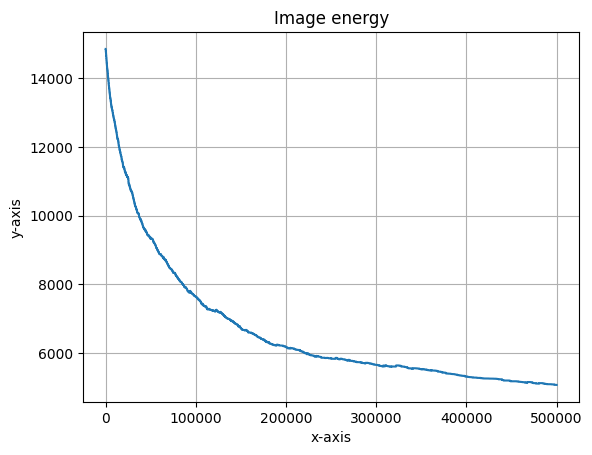

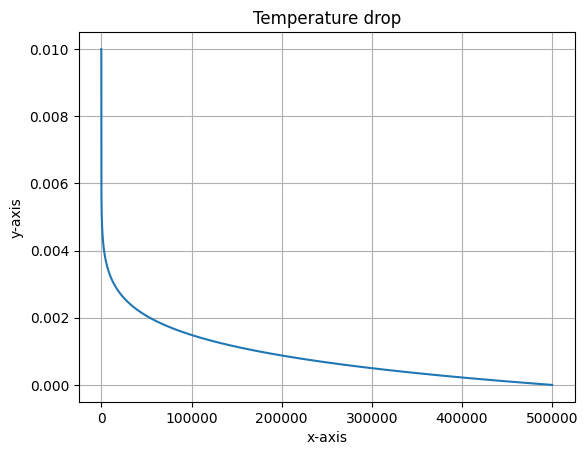

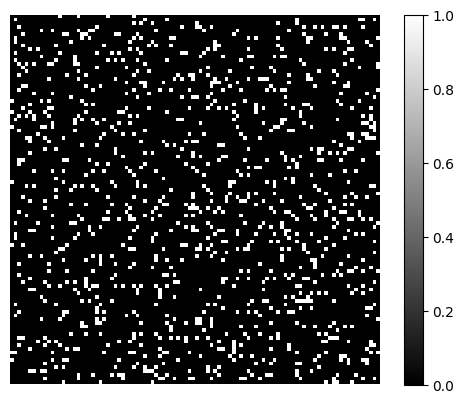

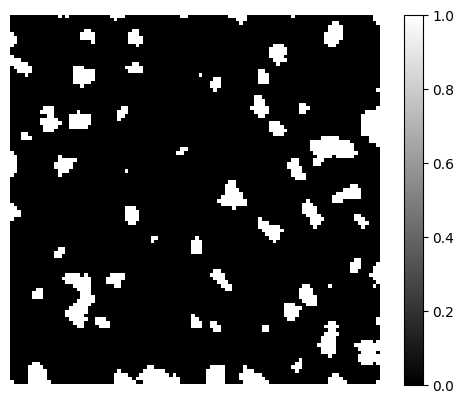

In [264]:
b_values = [0.0, 1.0]
test_binary_image(100, 0.1, b_values, 0.99, polynomial_change, 0.1, 1, 500000)

Start energy  33592.0
Finish energy  8214.0
Energy reduced by  76 %
1  changes per iteration


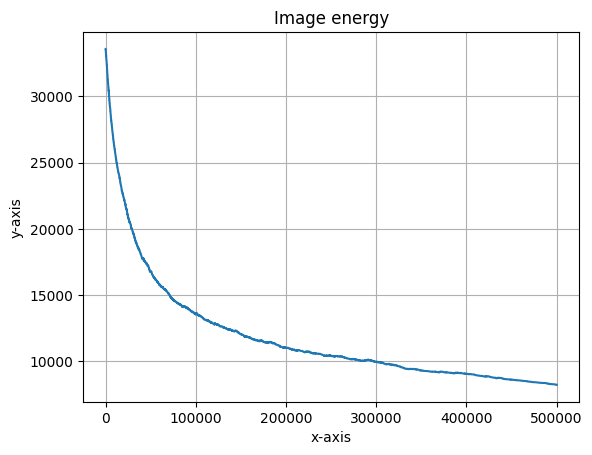

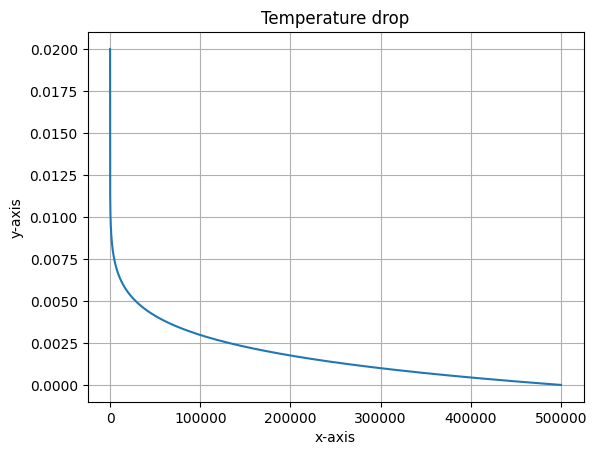

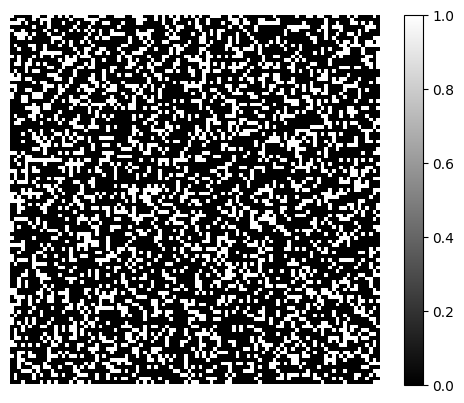

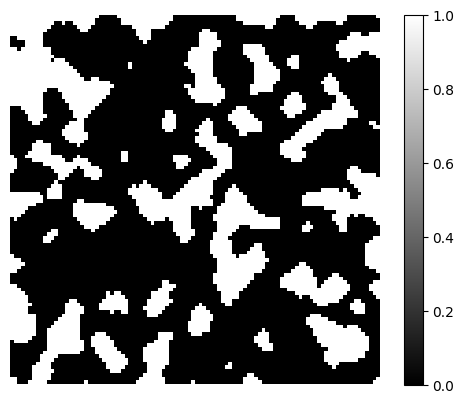

In [266]:
test_binary_image(100, 0.3, b_values, 0.98, polynomial_change, 0.1, 1, 500000)

Start energy  37732.0
Finish energy  8858.0
Energy reduced by  77 %
1  changes per iteration


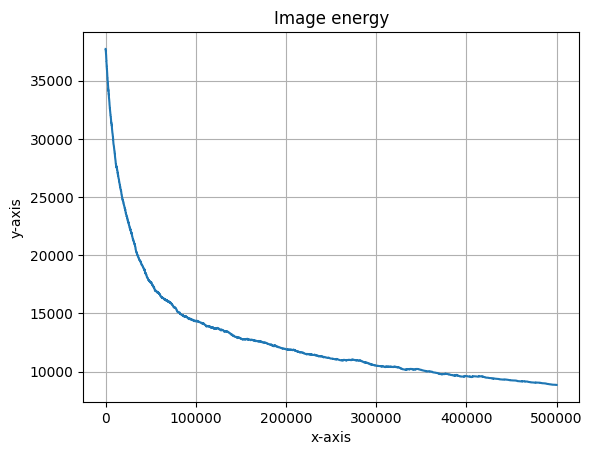

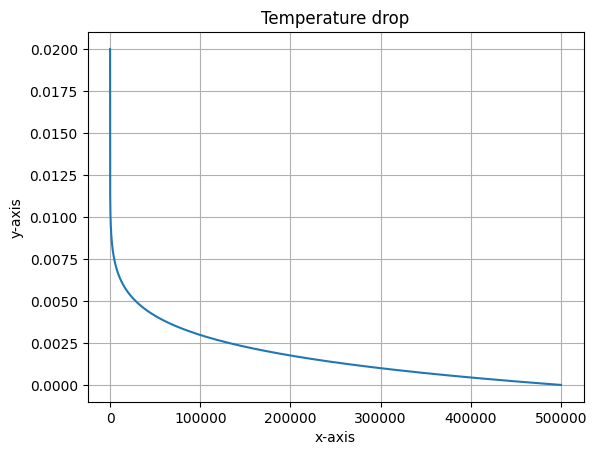

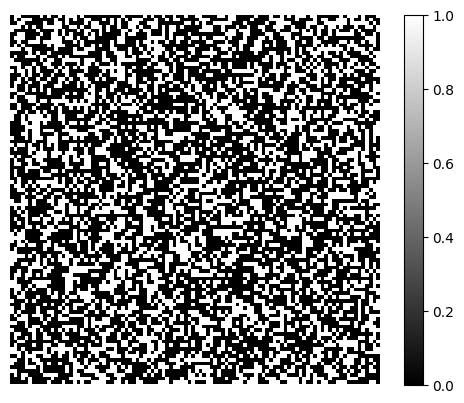

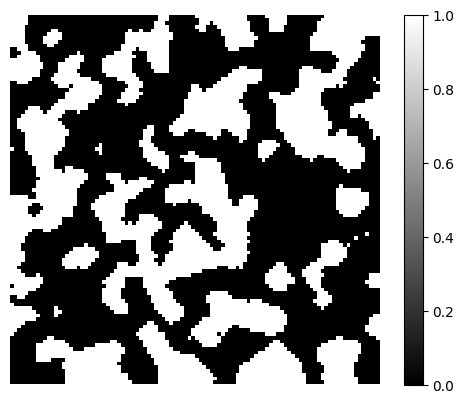

In [267]:
test_binary_image(100, 0.4, b_values, 0.98, polynomial_change, 0.1, 1, 500000)

In [144]:
print(calculate_average(50, 0.5, b_values, 0.95, polynomial_change, 5, 1, 100000, 10))

64


Start energy  10353.5
Finish energy  2198.0
Energy reduced by  79 %
1  changes per iteration


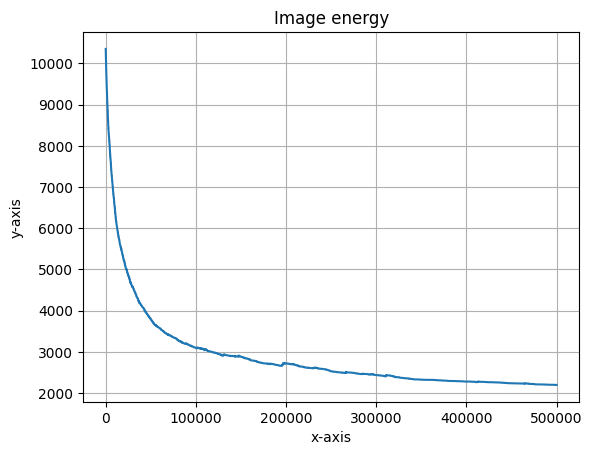

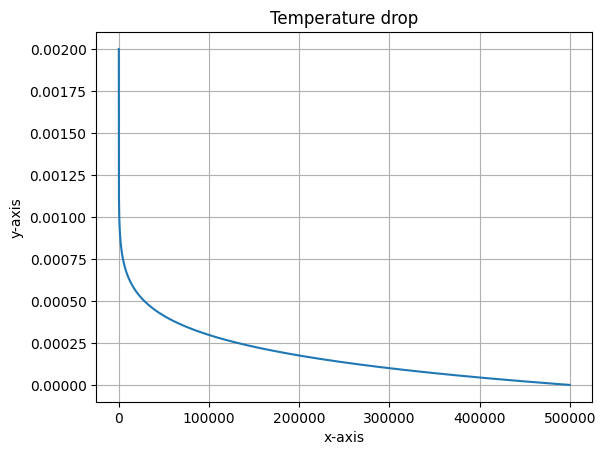

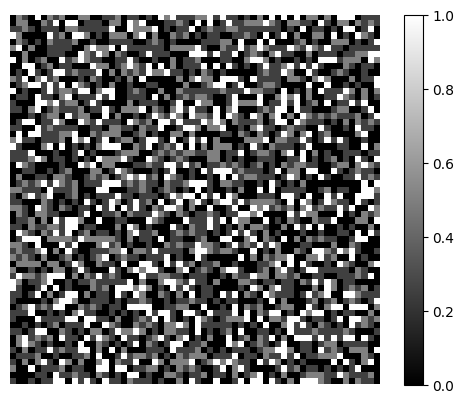

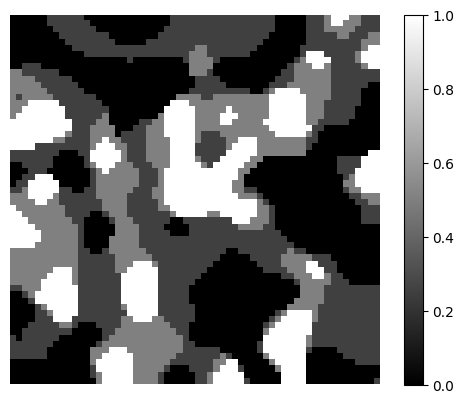

In [268]:
values025 = [0.0, 0.25, 0.5, 1.0]
test_binary_image(60, 0.35, values025, 0.998, polynomial_change, 0.1, 1, 500000)

Start energy  17745.500000000044
Finish energy  3676.0000000002365
Energy reduced by  79 %
1  changes per iteration


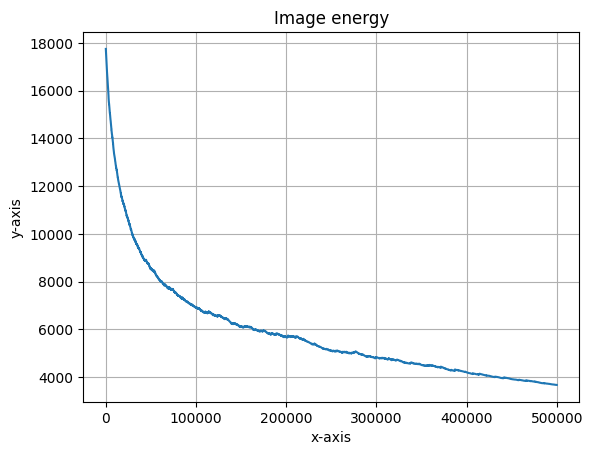

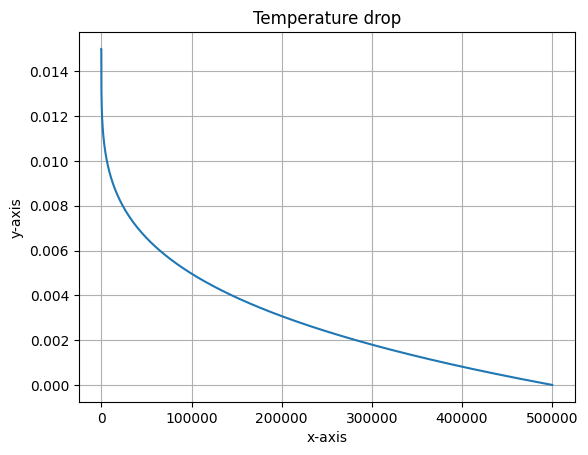

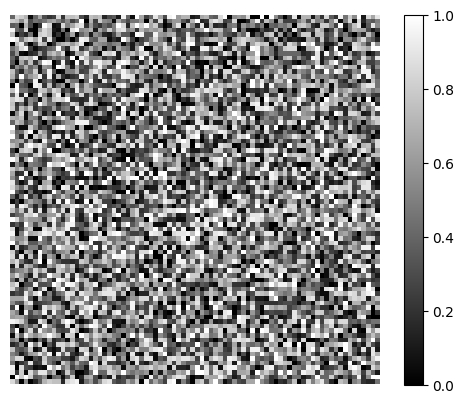

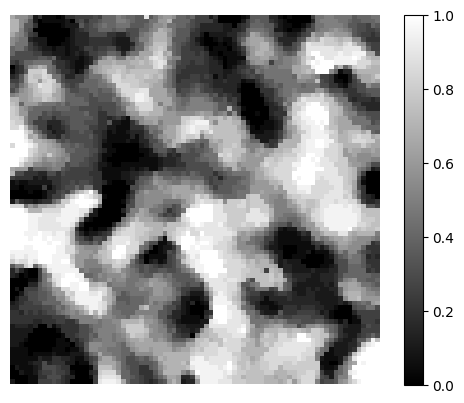

In [269]:
values005 = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
test_binary_image(80, 0.5, values005, 0.985, polynomial_change, 0.25, 1, 500000)

Start energy  696345.9999999985
Finish energy  232651.5999992161
Energy reduced by  67 %
1  changes per iteration


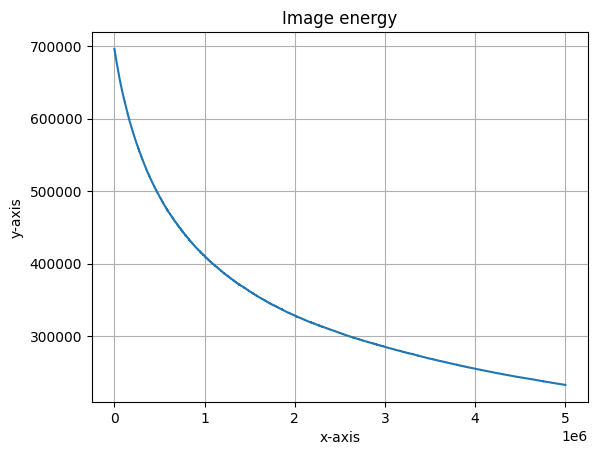

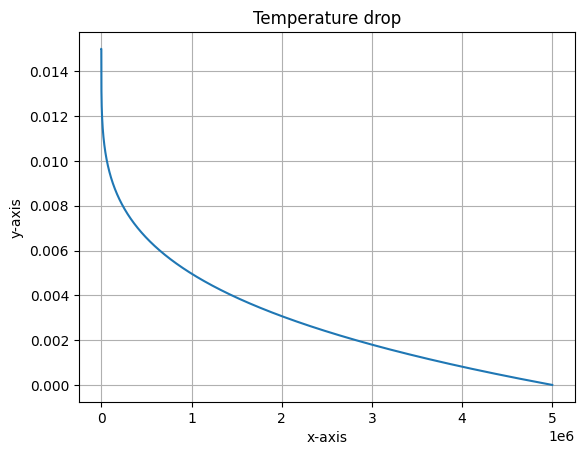

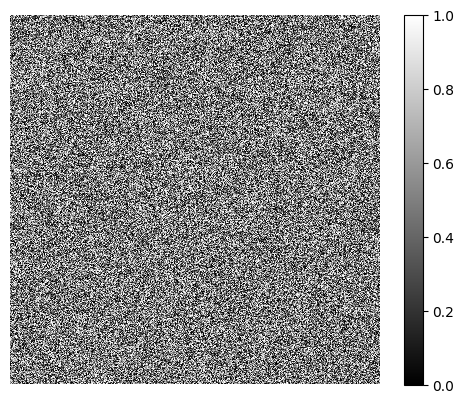

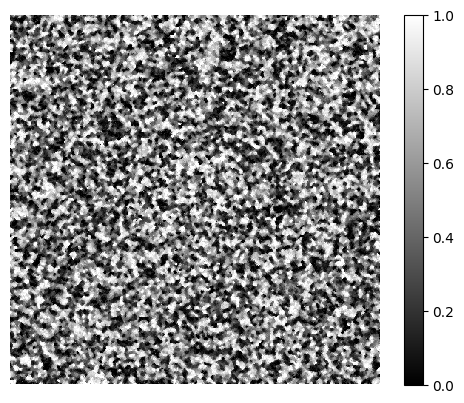

In [271]:
values001 = generate_pixel_values(0.02)
test_binary_image(500, 0.5, values005, 0.985, polynomial_change, 0.25, 1, 5000000)

In [189]:
def draw_sudoku(sudoku):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(np.zeros_like(sudoku), cmap='Greys', vmin=-1, vmax=1)

    for i in range(9):
        for j in range(9):
            c = sudoku[j][i]
            if c != 0:
                ax.text(i, j, str(c), va='center', ha='center')

    for i in range(9):
        ax.axhline(i - 0.5, color='black', linewidth=1)
        ax.axvline(i - 0.5, color='black', linewidth=1)

    for i in range(0, 8, 3):
        ax.axhline(i - 0.5, color='black', linewidth=3)
        ax.axvline(i - 0.5, color='black', linewidth=3)

    plt.xticks([])
    plt.yticks([])
    plt.show()

Żeby przygotować sudoku pod algorytm, wypełniam je wszystkimi liczbami losowo, zapamiętując których pól nie mogę ruszyć.

In [190]:
def fill_sudoku(sudoku):
    numbers = [9 for _ in range(9)]
    empty_cells = []
    filled_cells = []
    for i in range(9):
        for j in range(9):
            if sudoku[i][j] == 0:
                empty_cells.append((i, j))
            
            else:
                numbers[sudoku[i][j] - 1] -= 1
                filled_cells.append((i, j))
    
    for i in range(len(numbers)):
        for _ in range(numbers[i]):
            tup = random.choice(empty_cells)
            empty_cells.remove(tup)
            sudoku[tup[0]][tup[1]] = i + 1
    
    return filled_cells

In [191]:
def calculate_sudoku_cost(sudoku):
    cost = 0
    sets = [set() for _ in range(27)]
    for i in range(9):
        for j in range(9):
            sets[i].add(sudoku[i][j])
            sets[j + 9].add(sudoku[i][j])
            sets[3*(i//3) + j//3 + 18].add(sudoku[i][j])
        
    for i in range(len(sets)):
         cost += 9 - len(sets[i])
    
    return cost

In [192]:
def swap_cells(sudoku, filled_cells):
    a = random.randint(0, 8)
    b = random.randint(0, 8)
    
    while (a, b) in filled_cells:
        a = random.randint(0, 8)
        b = random.randint(0, 8)
    
    c = random.randint(0, 8)
    d = random.randint(0, 8)
    
    while (c, d) in filled_cells or (c, d) == (a, b) or sudoku[c][d] == sudoku[a][b]:
        c = random.randint(0, 8)
        d = random.randint(0, 8)
    
    sudoku[a][b], sudoku[c][d] = sudoku[c][d], sudoku[a][b]

## Algorytm symulowanego wyżarzania do rozwiązywania sudoku

Parametrami algorytmu są kolejno:
- ```sudoku``` sudoku dostarczone w formie listy dwuwymiarowej z liczbami ```int``` (w pustych polach są zera)
- ```st``` startowe prawdopodobieństwo wyboru **lepszego** rozwiązania
- ```f``` funkcja według której temperatura będzie spadać
- ```t``` parametr do funkcji ```polynomial_change``` określający stopień wielomianu
- ```iterations``` liczba iteracji

In [193]:
def solve_sudoku(sudoku, st, f, t, iterations):
    states = []
    temperature = []    
    best_result = (float('inf'), -1)
    
    filled_cells = fill_sudoku(sudoku)
    
    current_cost = calculate_sudoku_cost(sudoku)
    
    var = (1 - st)/(iterations**t)
    heat = st
    
    for i in range(iterations):
        states.append(current_cost)
        if current_cost == 0:
            break
        
        candidate = deepcopy(sudoku)
        swap_cells(candidate, filled_cells)
        candidate_cost = calculate_sudoku_cost(candidate)
        
        best_result = min(best_result, min((current_cost, sudoku), (candidate_cost, candidate)))
        
        if current_cost > candidate_cost:
            sudoku, candidate = candidate, sudoku
            current_cost, candidate_cost = candidate_cost, current_cost
        
        if random.random() > heat:
            sudoku, candidate = candidate, sudoku
            current_cost, candidate_cost = candidate_cost, current_cost
        
        temperature.append(1 - heat)
        heat = f(i, var, t, st)
    
    return states, best_result[0], best_result[1]

In [194]:
def test_sudoku_solver(sudoku, st, f, t, iterations):
    print("Input sudoku: ")
    draw_sudoku(sudoku)
    graph, c, output_sudoku = solve_sudoku(sudoku, st, f, t, iterations)
    x = list(range(len(graph)))
    plot_solution(x, graph, "Sudoku cost")
    print("Best cost achieved: ", c)
    print("Output sudoku: ")
    draw_sudoku(output_sudoku)

Funkcja ```try_solving``` wywołuje funkcję ```solve_sudoku``` aż zwróci ona koszt $0$, co będzie znaczyło że sudoku jest rozwiązane

In [195]:
def try_solving(sudoku, st, f, t, iterations):
    while True:
        input_sudoku = deepcopy(sudoku)
        graph, c, output_sudoku = solve_sudoku(input_sudoku, st, f, t, iterations)
        if c == 0:
            break
    
    print("Input sudoku: ")
    draw_sudoku(sudoku)
    print("Solved sudoku: ")
    draw_sudoku(output_sudoku)
    x = list(range(len(graph)))
    plot_solution(x, graph, "Sudoku cost")

Input sudoku: 


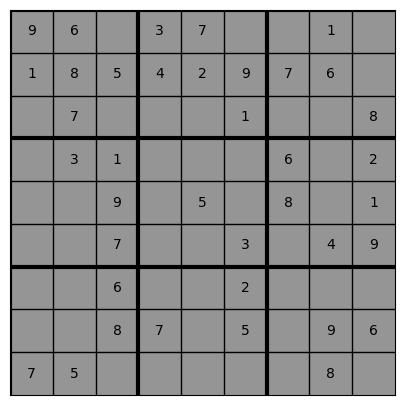

Solved sudoku: 


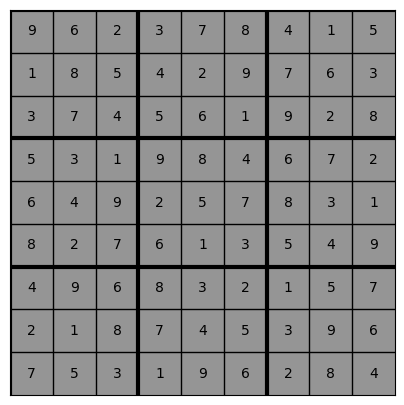

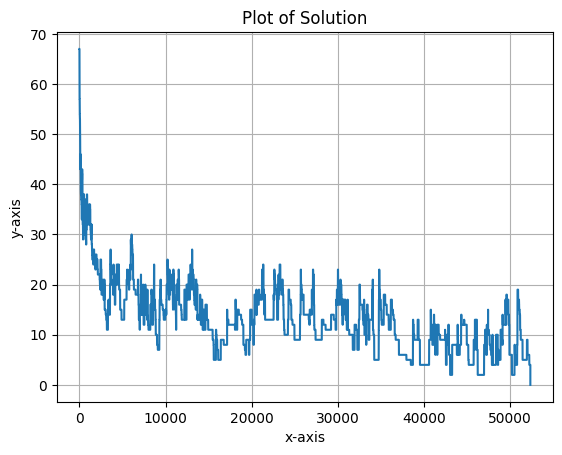

In [187]:
easy_sudoku = [
    [9, 6, 0, 3, 7, 0, 0, 1, 0],
    [1, 8, 5, 4, 2, 9, 7, 6, 0],
    [0, 7, 0, 0, 0, 1, 0, 0, 8],
    [0, 3, 1, 0, 0, 0, 6, 0, 2],
    [0, 0, 9, 0, 5, 0, 8, 0, 1],
    [0, 0, 7, 0, 0, 3, 0, 4, 9],
    [0, 0, 6, 0, 0, 2, 0, 0, 0],
    [0, 0, 8, 7, 0, 5, 0, 9, 6],
    [7, 5, 0, 0, 0, 0, 0, 8, 0]
]

# test_sudoku_solver(easy_sudoku, 0.98, polynomial_change, 0.1, 200000)
try_solving(easy_sudoku, 0.98, polynomial_change, 0.1, 200000)

Input sudoku: 


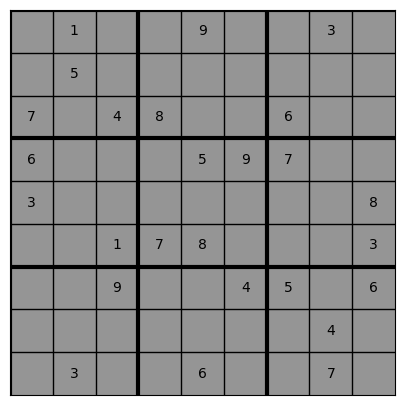

Solved sudoku: 


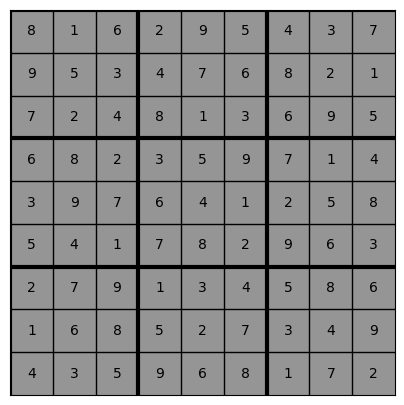

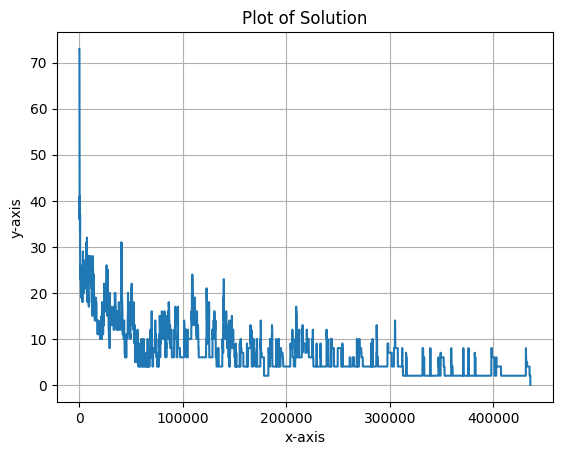

In [200]:
medium_sudoku = [
    [0, 1, 0, 0, 9, 0, 0, 3, 0],
    [0, 5, 0, 0, 0, 0, 0, 0, 0],
    [7, 0, 4, 8, 0, 0, 6, 0, 0],
    [6, 0, 0, 0, 5, 9, 7, 0, 0],
    [3, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 1, 7, 8, 0, 0, 0, 3],
    [0, 0, 9, 0, 0, 4, 5, 0, 6],
    [0, 0, 0, 0, 0, 0, 0, 4, 0],
    [0, 3, 0, 0, 6, 0, 0, 7, 0]
]
# test_sudoku_solver(medium_sudoku, 0.99, polynomial_change, 0.05, 500000)
try_solving(medium_sudoku, 0.99, polynomial_change, 0.05, 500000)

In [207]:
hard_sudoku = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 8, 5],
    [0, 0, 1, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 7, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 1, 0, 0],
    [0, 9, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 0, 7, 3],
    [0, 0, 2, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 9]
]

try_solving(hard_sudoku, 0.99, polynomial_change, 0.05, 1000000)
# test_sudoku_solver(hard_sudoku, 0.99, polynomial_change, 0.1, 500000)

KeyboardInterrupt: 

Nie udało się w rozsądnym czasie, rozwiązać trudnego sudoku :(

Input sudoku: 


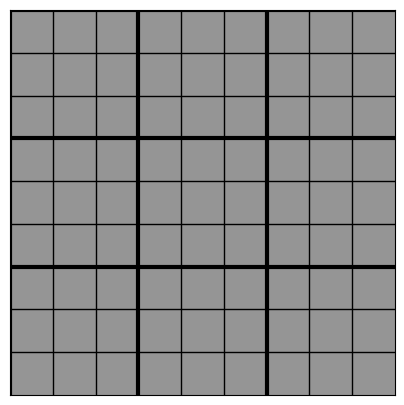

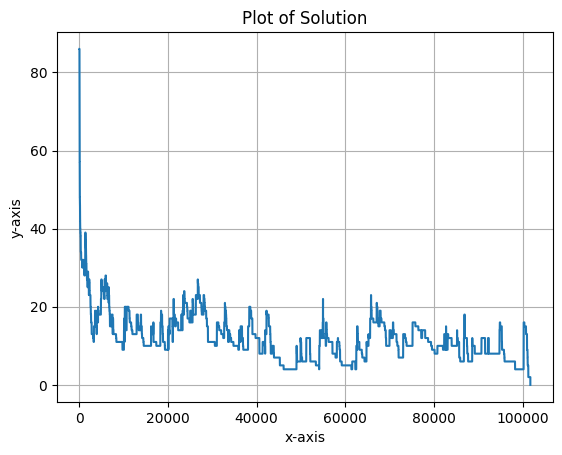

Best cost achieved:  0
Output sudoku: 


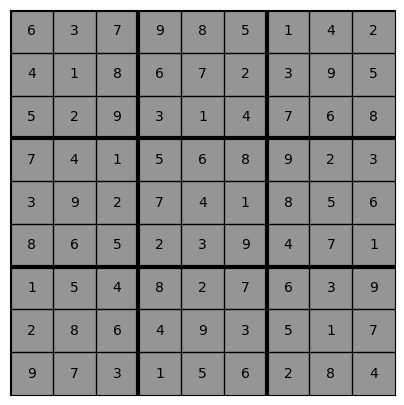

In [138]:
empty_sudoku = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
]
test_sudoku_solver(empty_sudoku, 0.987, polynomial_change, 0.03, 500000)